# BigContest Survival Analysis

# 1. Setting Environment

## 1.1 Load libraires

In [4]:
library(data.table)
library(dplyr)
library(tidyr)
library(survival)
library(ggplot2)
library(survminer)

## 1.2 Load data

In [6]:
activity <- fread("data/train_activity_new.csv", stringsAsFactors = F)
label    <- fread("data/train_label.csv", stringsAsFactors = F) %>%
  mutate(label = factor(label, levels = c("retained", "2month", "month", "week")))

Read 440323 rows and 39 (of 39) columns from 0.305 GB file in 00:00:14


# 2. Preprocessing

In [7]:
temp <- activity %>% select(acc_id, wk, cnt_dt) %>%
  spread(key = "wk", value = "cnt_dt") %>% left_join(label, by = "acc_id")
temp[is.na(temp)] <- 0
names(temp)[2:9] <- paste0("wk", 1:8)
head(temp)

acc_id,wk1,wk2,wk3,wk4,wk5,wk6,wk7,wk8,label
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,0,0,0,0,0,0,5,7,week
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,3,3,2,4,3,4,3,3,retained
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,0,0,2,2,2,0,1,5,retained
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,3,0,6,7,0,2,7,6,month
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,0,1,0,0,0,0,0,2,2month
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,7,7,6,3,2,4,6,4,month


In [8]:
temp2 <- apply(temp[,2:9], 2, function(x) {ifelse(x > 0, 1, x)}) %>% data.frame()
head(temp2)

wk1,wk2,wk3,wk4,wk5,wk6,wk7,wk8
0,0,0,0,0,0,1,1
1,1,1,1,1,1,1,1
0,0,1,1,1,0,1,1
1,0,1,1,0,1,1,1
0,1,0,0,0,0,0,1
1,1,1,1,1,1,1,1


In [9]:
survival <- temp %>% select(acc_id, label) %>% cbind(temp2) %>%
  mutate(wk9  = ifelse(label == "week", 0, 1),
         wk10 = ifelse(label %in% c("week", "month"), 0, 1),
         wk11 = ifelse(label == "retained", 1, 0))

survival$time <- survival %>% select(-acc_id, -label) %>% rowSums()
survival$churn <- ifelse(survival$label == "retained", 0, 1)
survival_df <- survival %>% select(acc_id, time, churn, label)
head(survival_df)

acc_id,time,churn,label
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,2,1,week
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,11,0,retained
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,8,0,retained
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,7,1,month
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,4,1,2month
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,9,1,month


In [13]:
summary(factor(survival_df$time))

1     2     3     4     5     6     7     8     9    10    11 
 8456 12804 14780  7666  5700  4980  7852  7426  9680  5833 14823

# 3. Survival Analysis

In [10]:
game.surv <- survfit(Surv(time, churn) ~ 1, data = survival_df)
summary(game.surv)

Call: survfit(formula = Surv(time, churn) ~ 1, data = survival_df)

 time n.risk n.event survival std.err lower 95% CI upper 95% CI
    1 100000    8456    0.915 0.00088        0.914        0.917
    2  91544   12804    0.787 0.00129        0.785        0.790
    3  78740   14780    0.640 0.00152        0.637        0.643
    4  63960    6468    0.575 0.00156        0.572        0.578
    5  56294    5076    0.523 0.00158        0.520        0.526
    6  50594    3883    0.483 0.00159        0.480        0.486
    7  45614    6988    0.409 0.00157        0.406        0.412
    8  37762    6015    0.344 0.00153        0.341        0.347
    9  30336    7077    0.264 0.00144        0.261        0.266
   10  20656    3453    0.220 0.00138        0.217        0.222

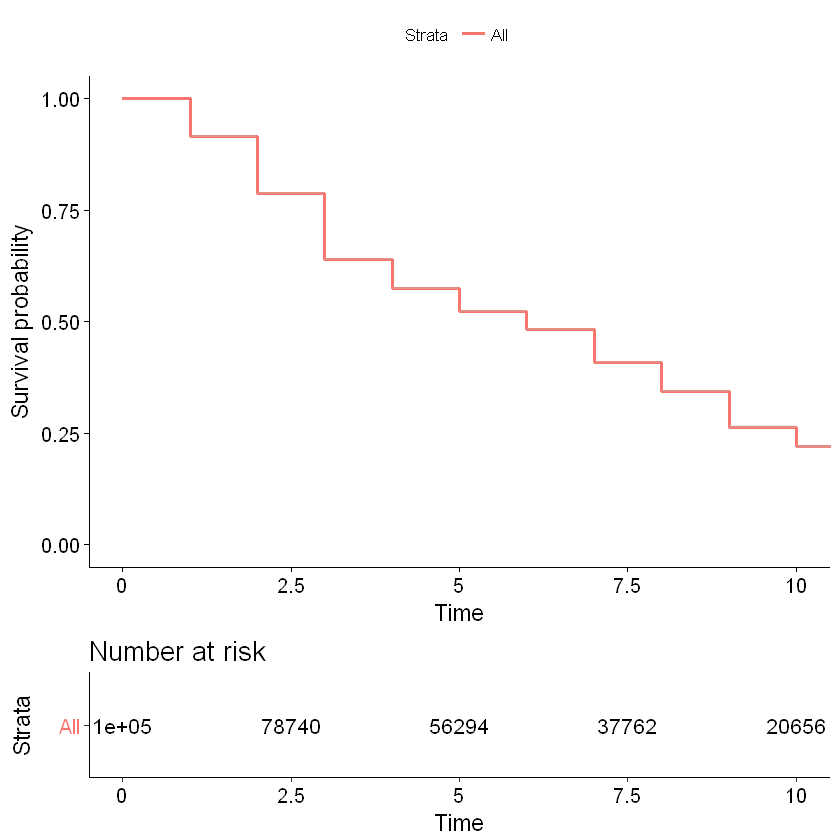

In [11]:
ggsurvplot(game.surv, censor = F, conf.int = T, risk.table = T)